In [36]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import ScalarFormatter
from scipy.ndimage import median_filter, gaussian_filter1d

# Library Imports
from dim_est.run.run_dsib_single_experiment import run_dsib_finite, run_dsib_infinite

# Plotting Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams.update({
    "font.family": "serif", "font.serif": "Times New Roman", "mathtext.fontset": "cm",
    'figure.dpi': 100, 'font.size': 16, 'axes.titlesize': 18, 'axes.labelsize': 16,
    'xtick.labelsize': 15, 'ytick.labelsize': 15, 'legend.fontsize': 14
})

# Global Constants
BATCH_SIZE = 128   # Standard batch size
N_EPOCHS = 100     # Long enough to overfit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
cfg_teacher = {
    "latent": {
        "latent_dim": 4,
        "mi_bits": 2.0 
    },
    "transform": {
        "mode": "teacher",
        "observe_dim_x": 500,
        "observe_dim_y": 500
    }
}

cfg_mixture = {
    "latent": {
        "latent_dim": 1, 
        "n_peaks": 8,
        "mu": 2.0,      # Widely separated
        "sig": 1.0,
        "mi_bits_peak": 2.0 
    },
    "transform": {
        "mode": "teacher", 
        "observe_dim_x": 500,
        "observe_dim_y": 500,
    }
}

In [26]:
fig_6_a_low = run_dsib_finite(
            dataset_type="joint_gaussian",
            setup="finite_data_epoch",
            outfile="temp_finite.h5", 
            dataset_overrides=cfg_teacher, 
            critic_type="hybrid", 
            save_trained_model_data_transform=False,
            critic_overrides={
                "embed_dim": 64,
                },

            training_overrides={
                "n_epoch": N_EPOCHS, 
                "batch_size": BATCH_SIZE, 
                "n_samples": 2**8, 
                "n_test_samples": 128,
                "eval_train_mode": True,
                "eval_train_mode_final": False,
                "show_progress": True,
                "smooth_sigma": 0,
                "smooth_win": 1,
            }
        )

# fig_6_a_high = run_dsib_finite(
#             dataset_type="joint_gaussian",
#             setup="finite_data_epoch",
#             outfile="temp_finite.h5", 
#             dataset_overrides=cfg_teacher, 
#             critic_type="hybrid", 
#             save_trained_model_data_transform=False,
#             critic_overrides={
#                 "embed_dim": 64,
#                 },

#             training_overrides={
#                 "n_epoch": N_EPOCHS, 
#                 "batch_size": BATCH_SIZE, 
#                 "n_samples": 2**12, 
#                 "n_test_samples": 128,
#                 "eval_train_mode": BATCH_SIZE,
#                 "eval_train_mode_final": False,
#                 "show_progress": True,
#                 "smooth_sigma": 0,
#                 "smooth_win": 1,

#             }
#         )

Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5


In [37]:
def smooth(arr, sigma=1, med_win=5):
    hist = np.array(arr)
    if len(hist) < 2: return hist
    nan_mask = np.isnan(hist)
    valid_hist = hist[~nan_mask]
    if len(valid_hist) == 0: return hist
    hist[nan_mask] = valid_hist[-1]
    if med_win > 1 and len(hist) >= med_win:
        hist = median_filter(hist, size=med_win, mode='reflect')
    if sigma > 0: hist = gaussian_filter1d(hist, sigma=sigma, mode='reflect')
    hist[nan_mask] = np.nan
    return hist

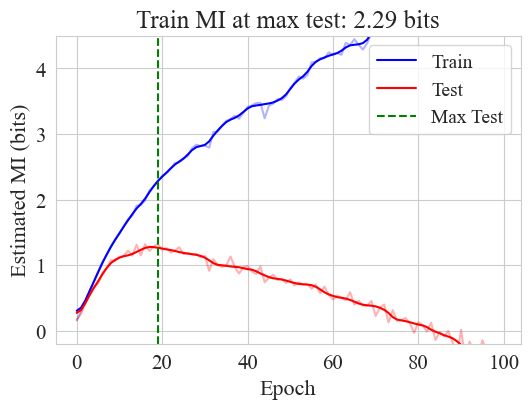

In [40]:
plt.plot(fig_6_a_low[0][0], c='b', alpha=0.3)
plt.plot(smooth(fig_6_a_low[0][0], sigma=1, med_win=5), c='b', label='Train')
plt.plot(fig_6_a_low[0][1], c='r', alpha=0.3)
plt.plot(smooth(fig_6_a_low[0][1], sigma=1, med_win=5), c='r', label='Test')

# plt.plot(fig_6_a_high[0][0], label='Train MI')
# plt.plot(fig_6_a_high[0][1], label='Test MI')
plt.xlabel('Epoch')
plt.ylabel('Estimated MI (bits)')
plt.axvline(x=np.argmax(fig_6_a_low[0][1]), color='g', linestyle='--', label='Max Test')
plt.title(f'Train MI at max test: {fig_6_a_low[0][0][np.argmax(fig_6_a_low[0][1])]:.2f} bits')
plt.legend()
plt.ylim(-0.2, 4.5);
# plt.xscale('log');
 

In [65]:
samples_lst = np.logspace(5, 15, num=11, dtype=int, base=2)
deff_lst_teacher_1 = np.zeros_like(samples_lst, dtype=float)
deff_lst_teacher_6 = np.zeros_like(samples_lst, dtype=float)
deff_lst_mixture = np.zeros_like(samples_lst, dtype=float)

cfg_teacher_1 = {
    "latent": {
        "latent_dim": 4,
        "mi_bits": 1.0 
    },
    "transform": {
        "mode": "teacher",
        "observe_dim_x": 500,
        "observe_dim_y": 500
    }
}

cfg_teacher_6 = {
    "latent": {
        "latent_dim": 4,
        "mi_bits": 6.0 
    },
    "transform": {
        "mode": "teacher",
        "observe_dim_x": 500,
        "observe_dim_y": 500
    }
}

cfg_mixture = {
    "latent": {
        "latent_dim": 1, 
        "n_peaks": 8,
        "mu": 2.0,      # Widely separated
        "sig": 1.0,
        "mi_bits_peak": 2.0 
    },
    "transform": {
        "mode": "teacher", 
        "observe_dim_x": 500,
        "observe_dim_y": 500,
    }
}

In [68]:
for i, n_samples in enumerate(tqdm(samples_lst)):
    print(f"Running for n_samples={n_samples} ({i+1}/{len(samples_lst)}), Teacher MI=1 bits")
    result = run_dsib_finite(
            dataset_type="joint_gaussian",
            setup="finite_data_epoch",
            outfile="temp_finite.h5", 
            dataset_overrides=cfg_teacher_1, 
            critic_type="hybrid", 
            save_trained_model_data_transform=False,
            critic_overrides={
                "embed_dim": 64,
                },

            training_overrides={
                "n_epoch": N_EPOCHS, 
                "batch_size": BATCH_SIZE, 
                "n_samples": n_samples, 
                "n_test_samples": BATCH_SIZE,
                "eval_train_mode": False,
                "eval_train_mode_final": False,
                "show_progress": False,
                "patience": 20,
            }
        )
    deff_lst_teacher_1[i] = result[2][0]

for i, n_samples in enumerate(tqdm(samples_lst)):
    print(f"Running for n_samples={n_samples} ({i+1}/{len(samples_lst)}), Teacher MI=6 bits")
    result = run_dsib_finite(
            dataset_type="joint_gaussian",
            setup="finite_data_epoch",
            outfile="temp_finite.h5", 
            dataset_overrides=cfg_teacher_6, 
            critic_type="hybrid", 
            save_trained_model_data_transform=False,
            critic_overrides={
                "embed_dim": 64,
                },

            training_overrides={
                "n_epoch": N_EPOCHS, 
                "batch_size": BATCH_SIZE, 
                "n_samples": n_samples, 
                "n_test_samples": BATCH_SIZE,
                "eval_train_mode": False,
                "eval_train_mode_final": False,
                "show_progress": False,
                "patience": 20,
            }
        )
    deff_lst_teacher_6[i] = result[2][0]

for i, n_samples in enumerate(tqdm(samples_lst)):
    print(f"Running for n_samples={n_samples} ({i+1}/{len(samples_lst)}), Mixture Dataset")
    result = run_dsib_finite(
            dataset_type="gaussian_mixture",
            setup="finite_data_epoch",
            outfile="temp_finite.h5", 
            dataset_overrides=cfg_mixture, 
            critic_type="hybrid", 
            save_trained_model_data_transform=False,
            critic_overrides={
                "embed_dim": 64,
                },

            training_overrides={
                "n_epoch": N_EPOCHS, 
                "batch_size": BATCH_SIZE, 
                "n_samples": n_samples, 
                "n_test_samples": BATCH_SIZE,
                "eval_train_mode": False,
                "eval_train_mode_final": False,
                "show_progress": False,
                "patience": 20,
            }
        )
    deff_lst_mixture[i] = result[2][0]

  0%|          | 0/11 [00:00<?, ?it/s]

Running for n_samples=32 (1/11), Teacher MI=1 bits
Using device: mps
Run completed; saved to temp_finite.h5
Running for n_samples=64 (2/11), Teacher MI=1 bits
Using device: mps
Run completed; saved to temp_finite.h5
Running for n_samples=128 (3/11), Teacher MI=1 bits
Using device: mps
Run completed; saved to temp_finite.h5
Running for n_samples=256 (4/11), Teacher MI=1 bits
Using device: mps
Run completed; saved to temp_finite.h5
Running for n_samples=512 (5/11), Teacher MI=1 bits
Using device: mps
Run completed; saved to temp_finite.h5
Running for n_samples=1024 (6/11), Teacher MI=1 bits
Using device: mps
Run completed; saved to temp_finite.h5
Running for n_samples=2048 (7/11), Teacher MI=1 bits
Using device: mps
Run completed; saved to temp_finite.h5
Running for n_samples=4096 (8/11), Teacher MI=1 bits
Using device: mps
Run completed; saved to temp_finite.h5
Running for n_samples=8192 (9/11), Teacher MI=1 bits
Using device: mps
Run completed; saved to temp_finite.h5
Running for n_sam

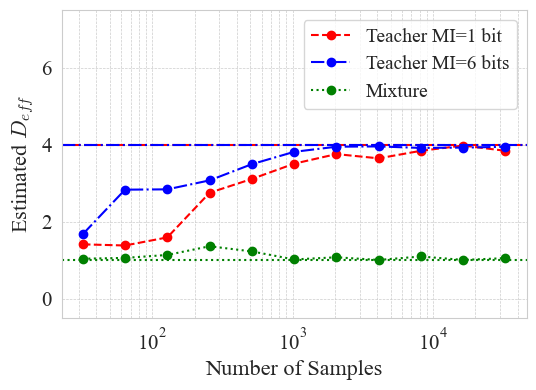

In [77]:
# plt.plot(samples_lst, deff_lst_teacher_1, marker='o', c = 'r', alpha=0.2)
# plt.plot(samples_lst, np.ceil(deff_lst_teacher_1), marker='o', c='r', label='Teacher MI=1 bit')
# plt.plot(samples_lst, deff_lst_teacher_6, marker='o', c = 'b', alpha=0.2)
# plt.plot(samples_lst, np.ceil(deff_lst_teacher_6), marker='o', c='b', label='Teacher MI=6 bits')
# plt.plot(samples_lst, deff_lst_mixture, marker='o', c = 'g', alpha=0.2)
# plt.plot(samples_lst, np.ceil(deff_lst_mixture), marker='o', c='g', label='Mixture')
plt.plot(samples_lst, deff_lst_teacher_1, marker='o', ls='--', c = 'r', label='Teacher MI=1 bit')
plt.axhline(y=4, color='r', linestyle='--')
plt.plot(samples_lst, deff_lst_teacher_6, marker='o', ls='-.', c = 'b', label='Teacher MI=6 bits')
plt.axhline(y=4, color='b', linestyle='-.')
plt.plot(samples_lst, deff_lst_mixture, marker='o', ls=':', c = 'g', label='Mixture')
plt.axhline(y=1, color='g', linestyle=':')

plt.xscale('log')
plt.xlabel('Number of Samples')
plt.ylabel('Estimated $D_{eff}$')
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.ylim(-0.5, 7.5)
plt.show()

In [83]:
KZ_lst = np.arange(1, 21)
deff_lst_teacher_1_KZ_256 = np.zeros_like(KZ_lst, dtype=float)
deff_lst_teacher_6_KZ_256 = np.zeros_like(KZ_lst, dtype=float)
deff_lst_teacher_1_KZ_4k = np.zeros_like(KZ_lst, dtype=float)
deff_lst_teacher_6_KZ_4k = np.zeros_like(KZ_lst, dtype=float)

In [84]:
for i, KZ in enumerate(tqdm(KZ_lst)):
    print(f"Running for KZ={KZ} ({i+1}/{len(KZ_lst)}), Teacher MI=1 bits, 256 samples")
    cfg_teacher_1 = {
        "latent": {
            "latent_dim": KZ,
            "mi_bits": 1.0 
        },
        "transform": {
            "mode": "teacher",
            "observe_dim_x": 500,
            "observe_dim_y": 500
        }
    }
    result = run_dsib_finite(
            dataset_type="joint_gaussian",
            setup="finite_data_epoch",
            outfile="temp_finite.h5", 
            dataset_overrides=cfg_teacher_1, 
            critic_type="hybrid", 
            save_trained_model_data_transform=False,
            critic_overrides={
                "embed_dim": 64,
                },

            training_overrides={
                "n_epoch": N_EPOCHS, 
                "batch_size": BATCH_SIZE, 
                "n_samples": 2**8, 
                "n_test_samples": BATCH_SIZE,
                "eval_train_mode": False,
                "eval_train_mode_final": False,
                "show_progress": False,
                "patience": 20,
            }
        )
    deff_lst_teacher_1_KZ_256[i] = result[2][0]

  0%|          | 0/20 [00:00<?, ?it/s]

Running for KZ=1 (1/20), Teacher MI=1 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=2 (2/20), Teacher MI=1 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=3 (3/20), Teacher MI=1 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=4 (4/20), Teacher MI=1 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=5 (5/20), Teacher MI=1 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=6 (6/20), Teacher MI=1 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=7 (7/20), Teacher MI=1 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=8 (8/20), Teacher MI=1 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=9 (9/20), Teacher MI=1 bits, 256 samples
Using device: mps
Run completed; saved t

In [87]:
for i, KZ in enumerate(tqdm(KZ_lst)):
    print(f"Running for KZ={KZ} ({i+1}/{len(KZ_lst)}), Teacher MI=1 bits, 4k samples")
    cfg_teacher_1 = {
        "latent": {
            "latent_dim": KZ,
            "mi_bits": 1.0 
        },
        "transform": {
            "mode": "teacher",
            "observe_dim_x": 500,
            "observe_dim_y": 500
        }
    }
    result = run_dsib_finite(
            dataset_type="joint_gaussian",
            setup="finite_data_epoch",
            outfile="temp_finite.h5", 
            dataset_overrides=cfg_teacher_1, 
            critic_type="hybrid", 
            save_trained_model_data_transform=False,
            critic_overrides={
                "embed_dim": 64,
                },

            training_overrides={
                "n_epoch": N_EPOCHS, 
                "batch_size": BATCH_SIZE, 
                "n_samples": 2**12, 
                "n_test_samples": BATCH_SIZE,
                "eval_train_mode": False,
                "eval_train_mode_final": False,
                "show_progress": False,
                "patience": 20,
            }
        )
    deff_lst_teacher_1_KZ_4k[i] = result[2][0]

  0%|          | 0/20 [00:00<?, ?it/s]

Running for KZ=1 (1/20), Teacher MI=1 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=2 (2/20), Teacher MI=1 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=3 (3/20), Teacher MI=1 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=4 (4/20), Teacher MI=1 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=5 (5/20), Teacher MI=1 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=6 (6/20), Teacher MI=1 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=7 (7/20), Teacher MI=1 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=8 (8/20), Teacher MI=1 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=9 (9/20), Teacher MI=1 bits, 4k samples
Using device: mps
Run completed; saved to temp_fi

In [99]:
for i, KZ in enumerate(tqdm(KZ_lst)):
    print(f"Running for KZ={KZ} ({i+1}/{len(KZ_lst)}), Teacher MI=6 bits, 256 samples")
    cfg_teacher_1 = {
        "latent": {
            "latent_dim": KZ,
            "mi_bits": 6.0 
        },
        "transform": {
            "mode": "teacher",
            "observe_dim_x": 500,
            "observe_dim_y": 500
        }
    }
    result = run_dsib_finite(
            dataset_type="joint_gaussian",
            setup="finite_data_epoch",
            outfile="temp_finite.h5", 
            dataset_overrides=cfg_teacher_1, 
            critic_type="hybrid", 
            save_trained_model_data_transform=False,
            critic_overrides={
                "embed_dim": 64,
                },

            training_overrides={
                "n_epoch": N_EPOCHS, 
                "batch_size": BATCH_SIZE, 
                "n_samples": 2**8, 
                "n_test_samples": BATCH_SIZE,
                "eval_train_mode": False,
                "eval_train_mode_final": False,
                "show_progress": False,
                "patience": 20,
            }
        )
    deff_lst_teacher_6_KZ_256[i] = result[2][0]

  0%|          | 0/20 [00:00<?, ?it/s]

Running for KZ=1 (1/20), Teacher MI=6 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=2 (2/20), Teacher MI=6 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=3 (3/20), Teacher MI=6 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=4 (4/20), Teacher MI=6 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=5 (5/20), Teacher MI=6 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=6 (6/20), Teacher MI=6 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=7 (7/20), Teacher MI=6 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=8 (8/20), Teacher MI=6 bits, 256 samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=9 (9/20), Teacher MI=6 bits, 256 samples
Using device: mps
Run completed; saved t

In [89]:
for i, KZ in enumerate(tqdm(KZ_lst)):
    print(f"Running for KZ={KZ} ({i+1}/{len(KZ_lst)}), Teacher MI=6 bits, 4k samples")
    cfg_teacher_1 = {
        "latent": {
            "latent_dim": KZ,
            "mi_bits": 6.0 
        },
        "transform": {
            "mode": "teacher",
            "observe_dim_x": 500,
            "observe_dim_y": 500
        }
    }
    result = run_dsib_finite(
            dataset_type="joint_gaussian",
            setup="finite_data_epoch",
            outfile="temp_finite.h5", 
            dataset_overrides=cfg_teacher_1, 
            critic_type="hybrid", 
            save_trained_model_data_transform=False,
            critic_overrides={
                "embed_dim": 64,
                },

            training_overrides={
                "n_epoch": N_EPOCHS, 
                "batch_size": BATCH_SIZE, 
                "n_samples": 2**12, 
                "n_test_samples": BATCH_SIZE,
                "eval_train_mode": False,
                "eval_train_mode_final": False,
                "show_progress": False,
                "patience": 20,
            }
        )
    deff_lst_teacher_6_KZ_4k[i] = result[2][0]

  0%|          | 0/20 [00:00<?, ?it/s]

Running for KZ=1 (1/20), Teacher MI=6 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=2 (2/20), Teacher MI=6 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=3 (3/20), Teacher MI=6 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=4 (4/20), Teacher MI=6 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=5 (5/20), Teacher MI=6 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=6 (6/20), Teacher MI=6 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=7 (7/20), Teacher MI=6 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=8 (8/20), Teacher MI=6 bits, 4k samples
Using device: mps
Run completed; saved to temp_finite.h5
Running for KZ=9 (9/20), Teacher MI=6 bits, 4k samples
Using device: mps
Run completed; saved to temp_fi

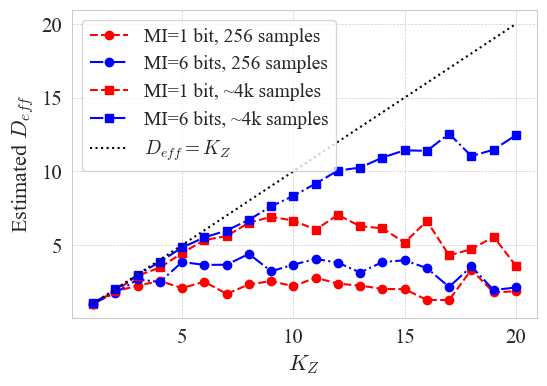

In [101]:
plt.plot(KZ_lst, deff_lst_teacher_1_KZ_256, marker='o', ls='--', c = 'r', label='MI=1 bit, 256 samples')
plt.plot(KZ_lst, deff_lst_teacher_6_KZ_256, marker='o', ls='-.', c = 'b', label='MI=6 bits, 256 samples')
plt.plot(KZ_lst, deff_lst_teacher_1_KZ_4k, marker='s', ls='--', c = 'r', label='MI=1 bit, ~4k samples')
plt.plot(KZ_lst, deff_lst_teacher_6_KZ_4k, marker='s', ls='-.', c = 'b', label='MI=6 bits, ~4k samples')
plt.plot(KZ_lst, KZ_lst, c='k', ls=':', label='$D_{eff}=K_Z$')
# plt.xscale('log')
plt.xlabel(r'$K_Z$')
plt.ylabel('Estimated $D_{eff}$')
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
# plt.ylim(-0.5, 7.5)
plt.show()

In [103]:
def calculate_participation_ratio(spectrum, eps=1e-12):
    """
    Computes participation ratio from eigenvalues.
    PR = (sum(lambda))^2 / sum(lambda^2)
    
    Args:
        spectrum (np.ndarray): Array of singular values.
        eps (float): Small value to prevent division by zero.
    """
    # Convert singular values to eigenvalues of covariance (lambda = sigma^2)
    lam = spectrum ** 2
    
    numerator = np.sum(lam) ** 2
    denominator = np.sum(lam ** 2).clip(min=eps)

    return numerator / denominator


In [106]:
from dim_est.datasets.data_generation import make_data_generator

def visualize_data_distribution(dataset_cfg, dataset_type="joint_gaussian", n_samples=2000, title=None, latent_dim=4):
    """
    Visualizes the raw relationship between X and Y.
    - 1D: Simple Scatter.
    - Low Dim (<=6): Component-wise subplots.
    - High Dim (>6): PCA Spectrum (Linear vs Nonlinear signature) + PC1 Correlation.
    """
    # 1. Generate Data
    gen = make_data_generator(dataset_type, dataset_cfg, device='cpu')
    x, y = gen(n_samples)
    x, y = x.numpy(), y.numpy()
    
    dim = x.shape[1]
    
    # 2. Determine Plot Type based on Dimension
    if dim == 1:
        # --- Case: 1D Mixture or Simple Gaussian ---
        plt.figure(figsize=(6, 5))
        plt.scatter(x, y, alpha=0.3, s=10)
        plt.xlabel("$X$")
        plt.ylabel("$Y$")
        plt.title(title or f"Raw Data Distribution ({dataset_type})")
        plt.show()
        
    elif dim <= 6:
        # --- Case: Low Dimensional (e.g. 4D) ---
        fig, axes = plt.subplots(1, dim, figsize=(4*dim, 4), sharex=True, sharey=True)
        if dim == 1: axes = [axes]
        
        for i, ax in enumerate(axes):
            ax.scatter(x[:, i], y[:, i], alpha=0.3, s=5)
            ax.set_title(f"Dim {i+1}")
            ax.set_xlabel(f"$X_{i+1}$")
            ax.set_ylabel(f"$Y_{i+1}$")
            
        plt.suptitle(title or f"Component-wise Correlation (Total Dims: {dim})")
        plt.tight_layout()
        plt.show()
        
    else:
        # --- Case: High Dimensional (e.g. 500D) ---
        # Strategy: Look at the specturm of the cross-covariance of X and Y
        cov_matrix = np.cov(x, y, rowvar=False)
        cov_xy = cov_matrix[:dim, dim:]  # Cross-covariance block
        singular_values = np.linalg.svd(cov_xy, compute_uv=False)
        plt.plot(range(1, len(singular_values)+1), singular_values, 'o-')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel("Component Index")
        plt.ylabel("Singular Value")
        plt.title(title or "Cross-Covariance Spectrum (X vs Y)")
        plt.axvline(latent_dim, color='r', linestyle='--', alpha=0.5, label=f"True ID={latent_dim}, PR={calculate_participation_ratio(singular_values):.2f}")
        plt.legend()
        plt.show()

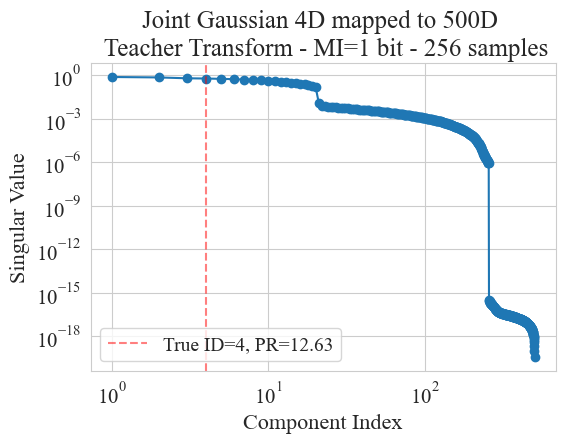

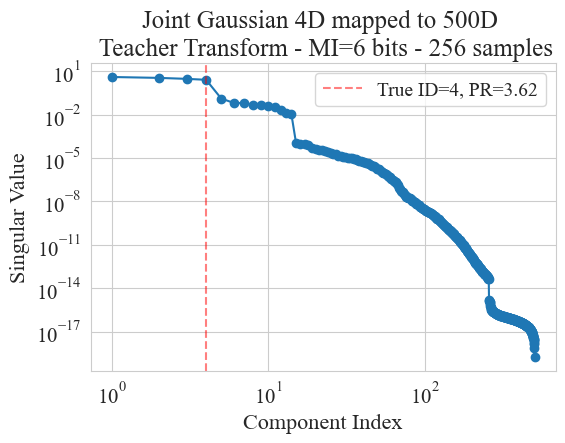

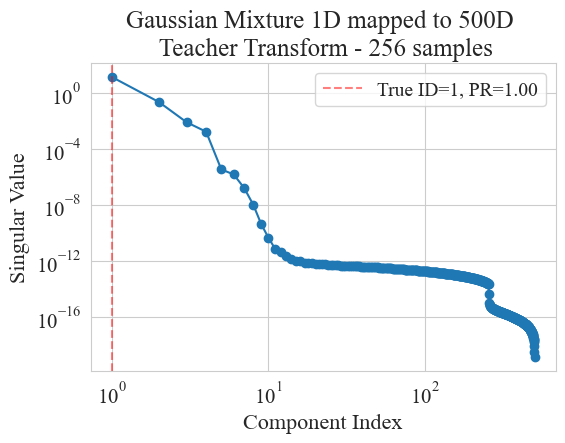

In [107]:
visualize_data_distribution(cfg_teacher_1, title="Joint Gaussian 4D mapped to 500D \n Teacher Transform - MI=1 bit - 256 samples", dataset_type="joint_gaussian", n_samples=256)
visualize_data_distribution(cfg_teacher_6, title="Joint Gaussian 4D mapped to 500D \n Teacher Transform - MI=6 bits - 256 samples", dataset_type="joint_gaussian", n_samples=256)
visualize_data_distribution(cfg_mixture, title="Gaussian Mixture 1D mapped to 500D \n Teacher Transform - 256 samples", dataset_type="gaussian_mixture", latent_dim=1, n_samples=256)

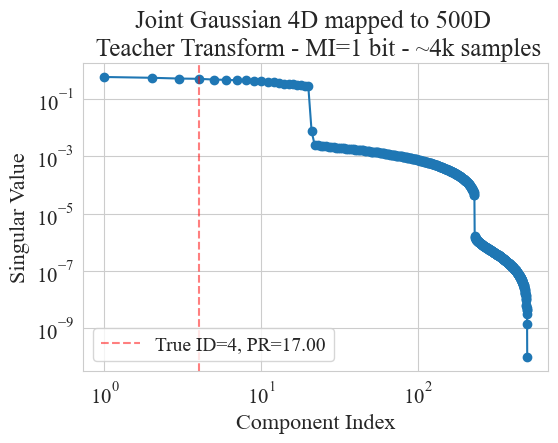

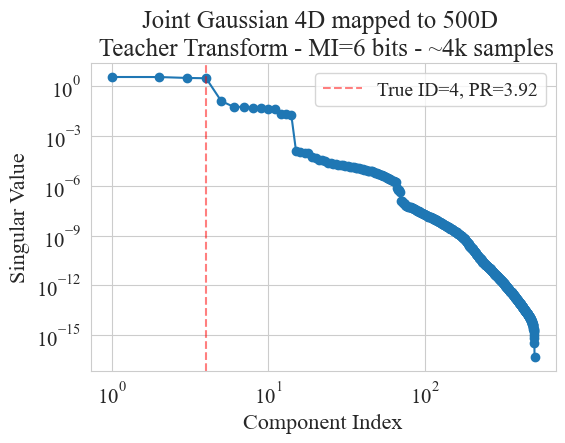

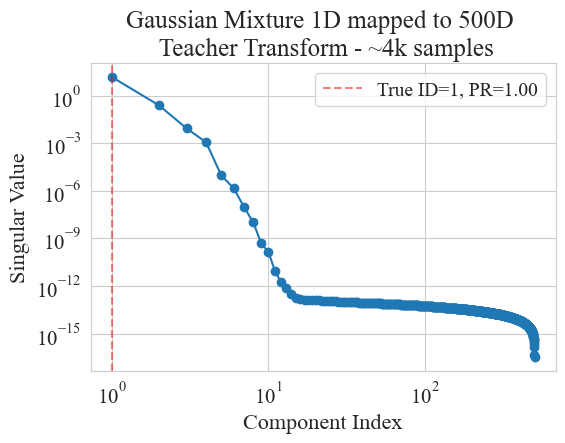

In [108]:
visualize_data_distribution(cfg_teacher_1, title="Joint Gaussian 4D mapped to 500D \n Teacher Transform - MI=1 bit - ~4k samples", dataset_type="joint_gaussian", n_samples=2**12)
visualize_data_distribution(cfg_teacher_6, title="Joint Gaussian 4D mapped to 500D \n Teacher Transform - MI=6 bits - ~4k samples", dataset_type="joint_gaussian", n_samples=2**12)
visualize_data_distribution(cfg_mixture, title="Gaussian Mixture 1D mapped to 500D \n Teacher Transform - ~4k samples", dataset_type="gaussian_mixture", latent_dim=1, n_samples=2**12)